In [39]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding, Flatten
from keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

data_gen = ImageDataGenerator(rescale=1.0/255)

In [2]:
imgdir = 'a5_images'
img_size = 64
batch_size = 32

train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [3]:
Xbatch, Ybatch = train_generator.next()

In [4]:
from matplotlib import pyplot as plt
plt.style.use('bmh')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

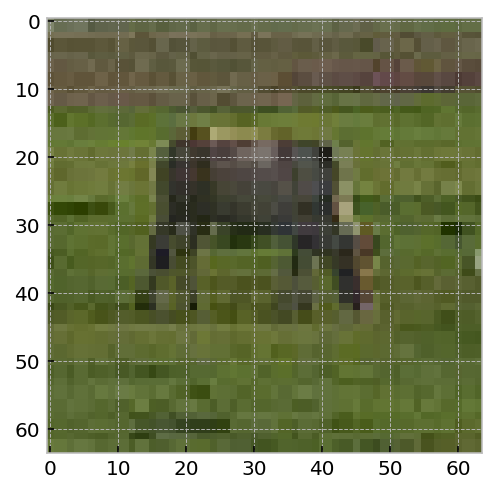

In [5]:
plt.imshow(Xbatch[0]);

In [6]:
Xbatch = Xbatch.reshape(Xbatch.shape[0], img_size, img_size, 3)
#x_test = x_test.reshape(Xbatch.shape[0], img_width, img_height, 1)
#Xbatch = Xbatch / 255
#x_test = x_test / 255

def make_convnet(img_width, img_height, c):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     input_shape=(img_width, img_height, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    #model.add(Dense(1, activation='elu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
    
cnn = make_convnet(img_size, img_size, 3)    

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
validation_generator = data_gen.flow_from_directory(
        imgdir + '/validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        shuffle=True)

Found 576 images belonging to 2 classes.


In [8]:
#cnn = make_convnet()
trainingBatchSize = math.ceil( 1600 / batch_size)
validationBatchSize = math.ceil( 576 / batch_size)
history = cnn.fit_generator(train_generator, 
                  validation_data=validation_generator, 
                  steps_per_epoch=trainingBatchSize,
                  validation_steps=validationBatchSize,
                  epochs=10,
                  use_multiprocessing=False)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
50/50 [==============================] - 22s 440ms/step - loss: 0.6874 - acc: 0.5787 - val_loss: 0.5926 - val_acc: 0.6997
Epoch 2/10
50/50 [==============================] - 19s 386ms/step - loss: 0.5577 - acc: 0.7244 - val_loss: 0.5529 - val_acc: 0.7135
Epoch 3/10
50/50 [==============================] - 20s 393ms/step - loss: 0.4632 - acc: 0.7963 - val_loss: 0.5366 - val_acc: 0.7378
Epoch 4/10
50/50 [==============================] - 19s 382ms/step - loss: 0.4152 - acc: 0.8250 - val_loss: 0.5375 - val_acc: 0.7569
Epoch 5/10
50/50 [==============================] - 19s 378ms/step - loss: 0.3626 - acc: 0.8456 - val_loss: 0.5315 - val_acc: 0.7882
Epoch 6/10
50/50 [==============================] - 19s 382ms/step - loss: 0.3153 - acc: 0.8700 - val_loss: 0.5114 - val_acc: 0.7847
Epoch 7/10
50/50 [==============================] - 20s 392ms/step - loss: 0.2376 - acc: 0.9075 - val_loss: 0.7659 - val_acc: 0.7378
Epoch 8/10
50/50 [===

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


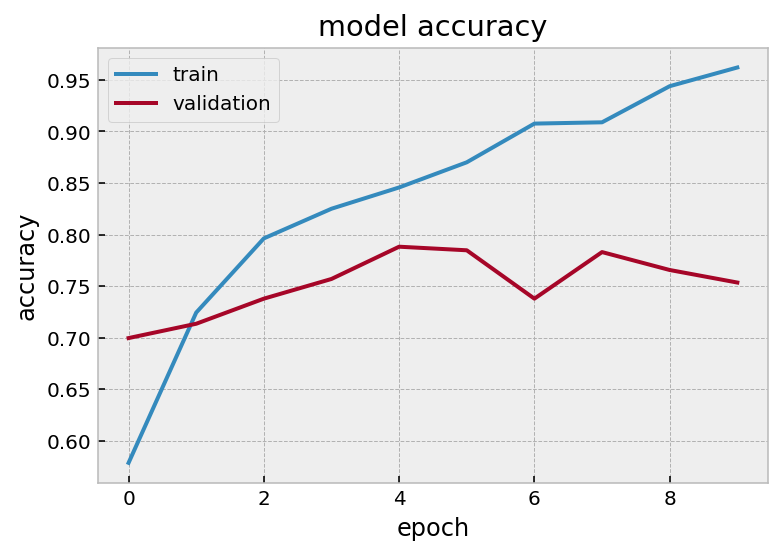

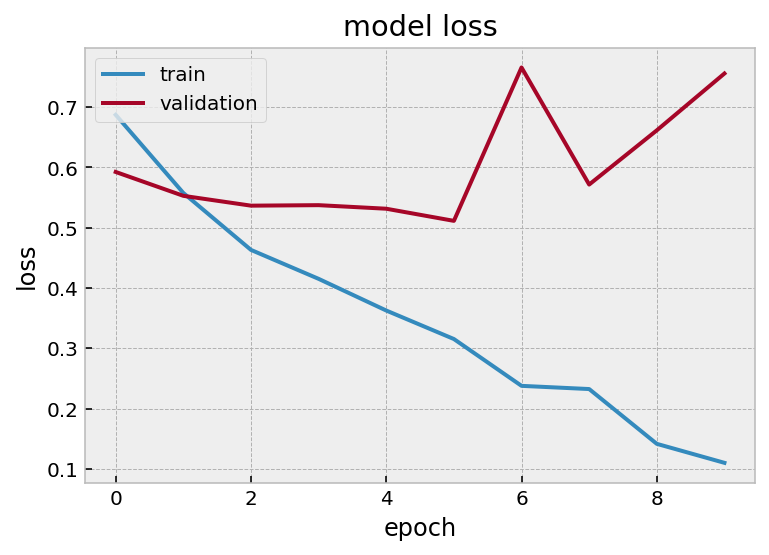

In [9]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

[[('n03594945', 'jeep', 0.92140627),
  ('n04252225', 'snowplow', 0.0243272),
  ('n03445924', 'golfcart', 0.014407205),
  ('n03930630', 'pickup', 0.012664951),
  ('n03478589', 'half_track', 0.005270824)]]

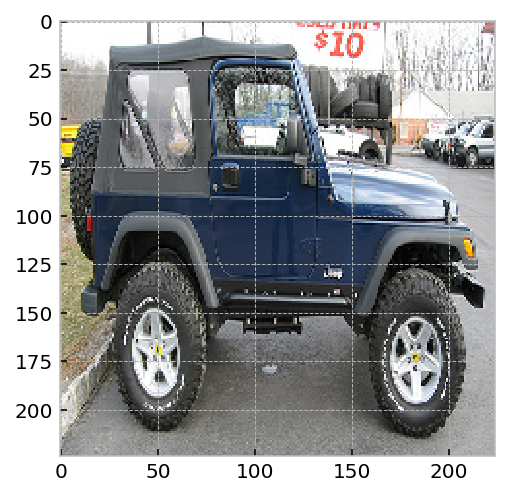

In [10]:
from keras import applications
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.preprocessing.image import load_img, img_to_array

vggmodel = applications.VGG16(weights='imagenet', include_top=True)
img = load_img('a5_images/validation/car/0000.jpg', target_size=(224,224))
plt.imshow(img);
imgArray = img_to_array(img)
imgVGG = preprocess_input(imgArray)
imgVGG = imgVGG.reshape(1, 224, 224, 3)
decode_predictions(vggmodel.predict(imgVGG))

In [11]:
feature_extractor = applications.VGG16(include_top=False, weights='imagenet',
                                       input_shape=(img_size, img_size, 3))
vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

def create_vgg16_features(subdir):
    generator = vgg_data_gen.flow_from_directory(
        imgdir + '/' + subdir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=False)
    if subdir == 'train' : step_size = 1600/batch_size
    else : step_size = 576/batch_size
    cnn_features = feature_extractor.predict_generator(generator, steps=step_size, verbose=1)
    with open('vgg16_' + subdir, 'wb') as f:
       np.save(f, cnn_features)

create_vgg16_features('train')
create_vgg16_features('validation')


Found 1600 images belonging to 2 classes.
50/50 [==============================] - 68s 1s/step
Found 576 images belonging to 2 classes.
18/18 [==============================] - 25s 1s/step


In [24]:
def make_vggnet():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model  

def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))    

def train_on_cnnfeatures():
    with open('vgg16_train', 'rb') as f:
        train_data = np.load(f)
    with open('vgg16_validation', 'rb') as f:
        val_data = np.load(f)
    vggmodel = make_vggnet()    
    history  = vggmodel.fit(x=train_data, 
                            y=get_labels(1600), 
                            epochs=10, 
                            validation_data=[val_data, get_labels(576)],
                            steps_per_epoch=32, 
                            validation_steps=32)
    return history, vggmodel

In [25]:
history, model = train_on_cnnfeatures()

Train on 1600 samples, validate on 576 samples
Epoch 1/10
32/32 [==============================] - 2s 75ms/step - loss: 1.3868 - acc: 0.8898 - val_loss: 1.3527 - val_acc: 0.8872
Epoch 2/10
32/32 [==============================] - 1s 37ms/step - loss: 0.4084 - acc: 0.9727 - val_loss: 1.2358 - val_acc: 0.8941
Epoch 3/10
32/32 [==============================] - 1s 46ms/step - loss: 0.2713 - acc: 0.9827 - val_loss: 1.2458 - val_acc: 0.8906
Epoch 4/10
32/32 [==============================] - 1s 42ms/step - loss: 0.2402 - acc: 0.9849 - val_loss: 1.2335 - val_acc: 0.8906
Epoch 5/10
32/32 [==============================] - 1s 39ms/step - loss: 0.2307 - acc: 0.9855 - val_loss: 1.2109 - val_acc: 0.8924
Epoch 6/10
32/32 [==============================] - 1s 35ms/step - loss: 0.2302 - acc: 0.9856 - val_loss: 1.2066 - val_acc: 0.8941
Epoch 7/10
32/32 [==============================] - 1s 38ms/step - loss: 0.2302 - acc: 0.9856 - val_loss: 1.2054 - val_acc: 0.8941
Epoch 8/10
32/32 [==================

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.ylim(0,1.5)
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [72]:
first_layer_weights = vggmodel.get_weights()[0]
first_layer_weights.shape
print(vggmodel.get_weights()[1].shape)

(64,)


In [28]:
def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k



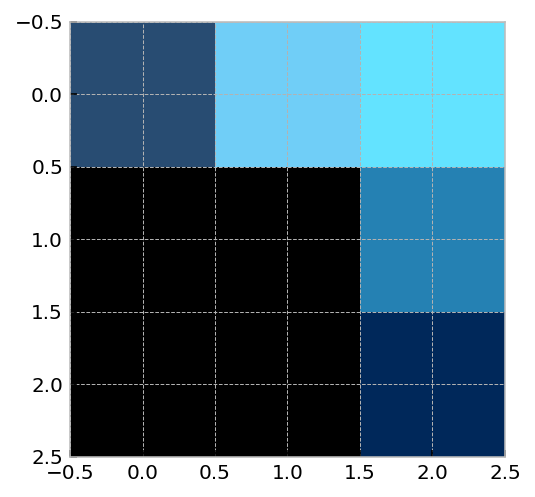

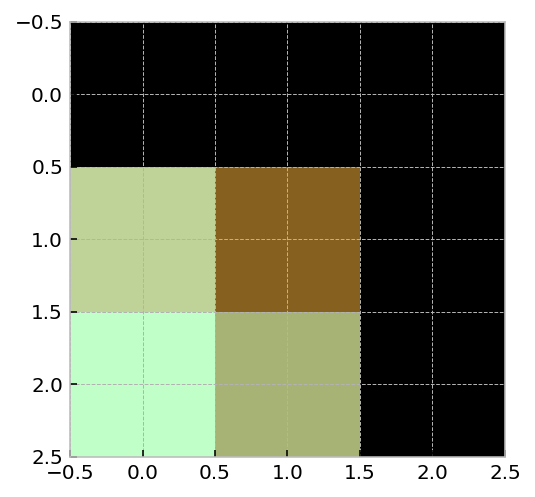

In [79]:
plt.imshow(kernel_image(vggmodel.get_weights()[0], 7, True))
plt.show()
plt.imshow(kernel_image(vggmodel.get_weights()[0], 7, False))
plt.show()

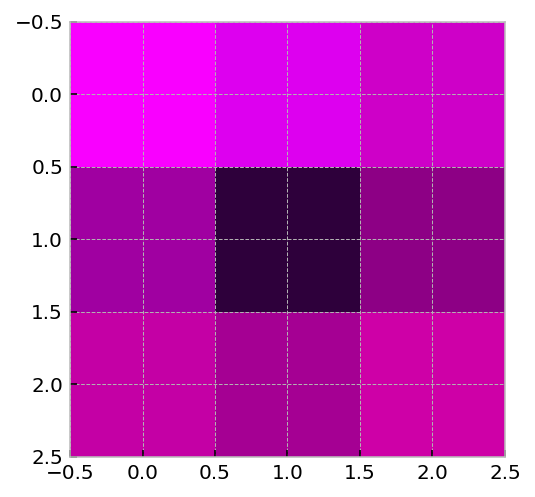

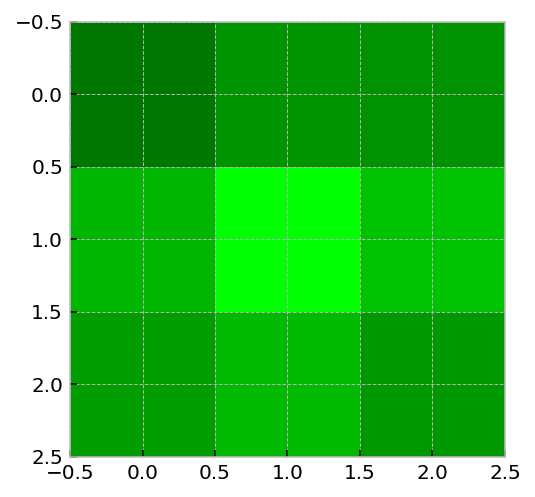

In [81]:
plt.imshow(kernel_image(vggmodel.get_weights()[0], 15, True))
plt.show()
plt.imshow(kernel_image(vggmodel.get_weights()[0], 15, False))
plt.show()

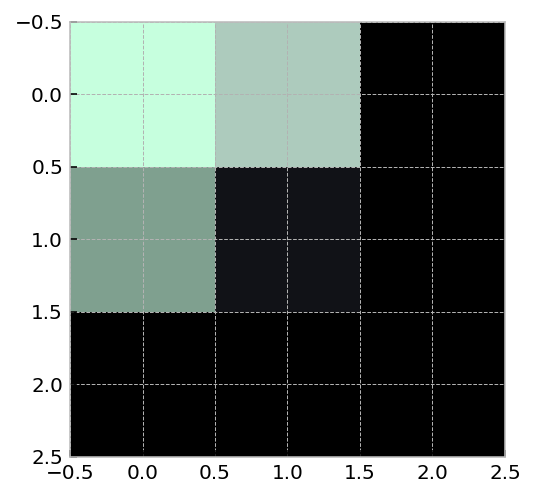

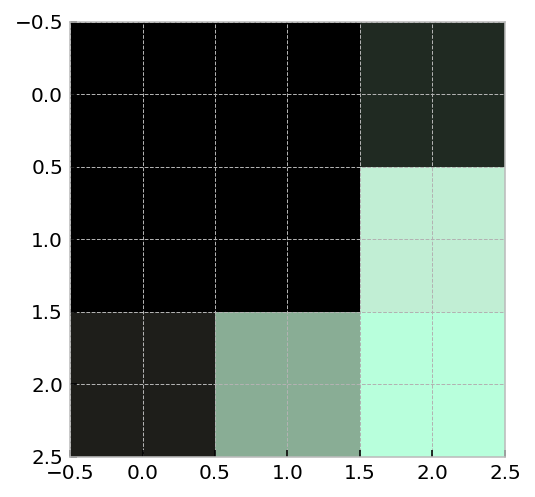

In [82]:
plt.imshow(kernel_image(vggmodel.get_weights()[0], 0, True))
plt.show()
plt.imshow(kernel_image(vggmodel.get_weights()[0], 0, False))
plt.show()

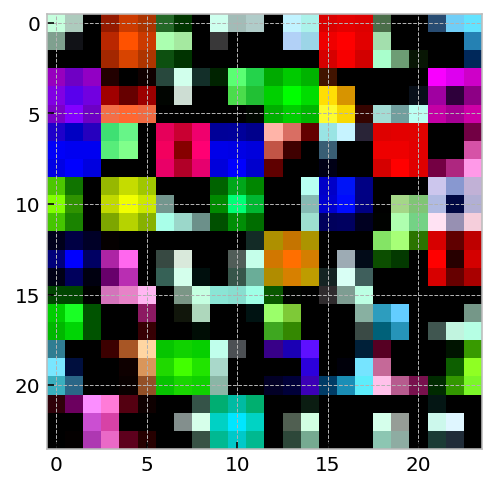

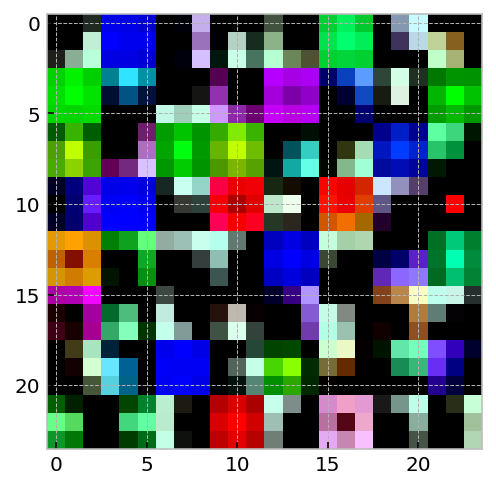

In [117]:
def ShowWholeFilter(b): 
    A = np.empty((3,3,3))
    for j in range(8):
        B = kernel_image(vggmodel.get_weights()[0], j*8, b)
        for i in range(7):
            B = np.hstack((B, kernel_image(vggmodel.get_weights()[0], j*8 + (i+1), b)))
        if j == 0:
            A = B
        else:
            A= np.vstack((A,B))
        if(j == 7):
            return A
plt.imshow(ShowWholeFilter(True))     
plt.show()
plt.imshow(ShowWholeFilter(False))     
plt.show()
